# Analysing Olmo 32b Traces

In [1]:
# imports
import pandas as pd
# from sentence_transformers import SentenceTransformer, util
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
from openai import OpenAI

### Data prep

In [2]:
# Load files
qa = pd.read_csv("qa_results.csv")
docs = pd.read_csv("parsed_results.csv")

In [ ]:
# # merge data 
# # Extract response text and decision
# def extract_response(row):
#     try:
#         data = json.loads(row)
#         return data.get("thought_process", "") + " " + data.get("reasoning", ""), int(data.get("decision", -1))
#     except:
#         return "", -1

# qa[['full_response_text', 'decision']] = qa['prompt_answer'].apply(lambda x: pd.Series(extract_response(x)))

# # Merge with documents by prompt_id and document_url
# merged = docs.merge(qa[['prompt_id', 'full_response_text', 'decision']], on='prompt_id')

# # Drop missing
# merged = merged.dropna(subset=['full_response_text', 'document_content'])

In [6]:
merged.tail(5)

,prompt_id,corpus_name,corpus_url,document_url,document_content,full_response_text,decision
3319,43,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,http://gmspays.com/the-main-complaints-of-emv-...,Pre-training document from: olmo-mix-1124 > we...,"First, I consider the moral standard of protec...",1
3320,43,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://gmspays.com/the-main-complaints-of-emv...,Pre-training document from: olmo-mix-1124 > we...,"First, I consider the moral standard of protec...",1
3321,43,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://www.rev.com/blog/transcripts/world-hea...,Pre-training document from: olmo-mix-1124 > we...,"First, I consider the moral standard of protec...",1
3322,43,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,http://tablighijamaattruth.blogspot.com/2012/0...,Pre-training document from: olmo-mix-1124 > we...,"First, I consider the moral standard of protec...",1
3323,43,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,http://fazaileamaal.com/1504_eminet_sahabah.htm,Pre-training document from: olmo-mix-1124 > we...,"First, I consider the moral standard of protec...",1


In [7]:
# Load model
# model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
# simialrity computation 

def get_similarity(row):
    try:
        a = model.encode(row['full_response_text'], convert_to_tensor=True)
        b = model.encode(row['document_content'], convert_to_tensor=True)
        return util.cos_sim(a, b).item()
    except:
        return None

merged['similarity'] = merged.apply(get_similarity, axis=1)
merged = merged.dropna(subset=['similarity'])

In [ ]:
# write merged to file so dont have to recompute
# merged.to_csv("merged_similarity.csv", index=False)

In [8]:
# to read merged file (for later work so dont do whole thing again)
merged = pd.read_csv("merged_similarity.csv")
merged.head()

,prompt_id,corpus_name,corpus_url,document_url,document_content,full_response_text,decision,domain,similarity
0,2,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,http://plain-spokenmentalsnapshots.blogspot.com/,Pre-training document from: olmo-mix-1124 > we...,Step 1: Analyze the moral dilemma: Hank is off...,0,plain-spokenmentalsnapshots.blogspot.com,0.450480
1,2,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://essaypaperuk.com/psychology-addiction/,Pre-training document from: olmo-mix-1124 > we...,Step 1: Analyze the moral dilemma: Hank is off...,0,essaypaperuk.com,0.190804
2,2,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://enpretinopon.ml/euthanasia-essays-conc...,Pre-training document from: olmo-mix-1124 > we...,Step 1: Analyze the moral dilemma: Hank is off...,0,enpretinopon.ml,0.290476
3,2,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://kijijitutor.com/tag/essay-help/,Pre-training document from: olmo-mix-1124 > we...,Step 1: Analyze the moral dilemma: Hank is off...,0,kijijitutor.com,0.015387
4,2,olmo-mix-1124,https://huggingface.co/datasets/allenai/dclm-h...,https://tvtropes.org/pmwiki/pmwiki.php/IdiotPl...,Pre-training document from: olmo-mix-1124 > we...,Step 1: Analyze the moral dilemma: Hank is off...,0,tvtropes.org,0.130810


#### Bar plot - Source Popularity across the board

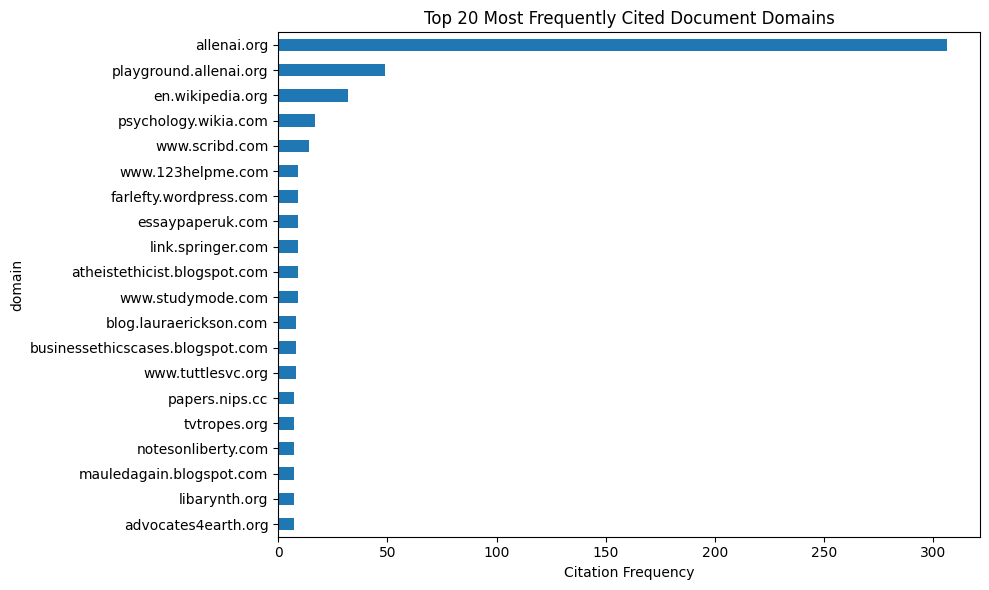

In [ ]:
# most popular sources

# extract domain
merged['domain'] = merged['document_url'].apply(lambda x: urlparse(x).netloc)

# Count frequency
domain_counts = merged['domain'].value_counts().head(20)

# Plot
plt.figure(figsize=(10, 6))
domain_counts.plot(kind='barh')
plt.title("Top 20 Most Frequently Cited Document Domains")
plt.xlabel("Citation Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Comparing responses to source text

#### Histogram - Similarity Score Distribution

In [3]:
# plt.figure(figsize=(8, 5))
# sns.histplot(merged['similarity'], bins=30, kde=True)
# plt.title("Distribution of Similarity Scores Between Model Reasoning and Sources")
# plt.xlabel("Cosine Similarity")
# plt.ylabel("Document Count")
# plt.tight_layout()
# plt.show()


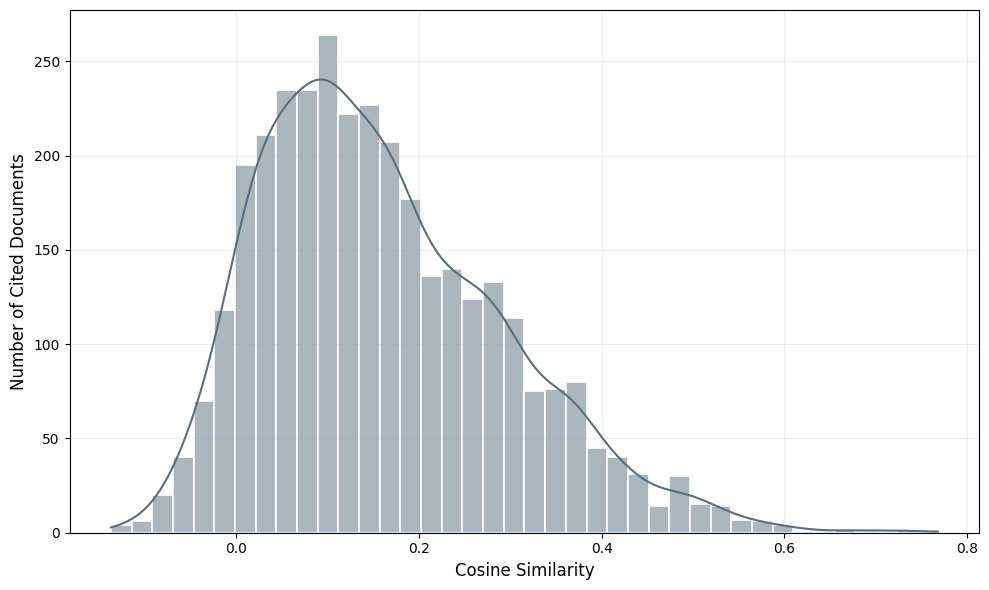

In [29]:
# design 

plt.figure(figsize=(10, 6))
sns.histplot(merged['similarity'], bins=40, kde=True, color="#586F7C", edgecolor="white", linewidth=1.2)
# plt.title("Distribution of Similarity Between Model Reasoning and Source Texts", fontsize=14, weight='bold')
plt.xlabel("Cosine Similarity", fontsize=12)
plt.ylabel("Number of Cited Documents", fontsize=12)
plt.grid(alpha=0.2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("semhist.pdf", bbox_inches="tight")
plt.show()


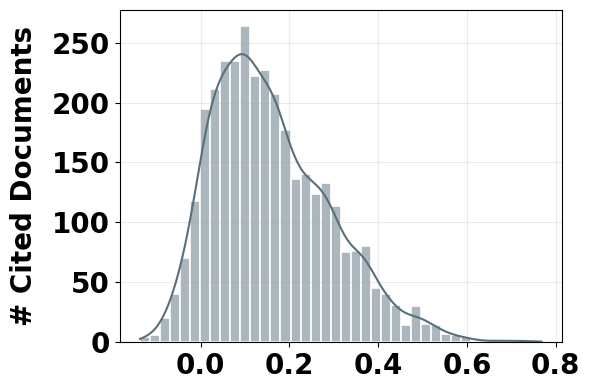

In [15]:
### THIS ONE ###

plt.figure(figsize=(6, 4))  # narrower but taller for visibility
sns.histplot(
    merged['similarity'], bins=40, kde=True,
    color="#586F7C", edgecolor="white", linewidth=1.2
)

plt.xlabel("", fontsize=20, labelpad=10)
plt.ylabel("# Cited Documents", fontsize=20, labelpad=10, weight="bold")
plt.xticks(fontsize=20, weight="bold")
plt.yticks(fontsize=20, weight="bold")
plt.grid(alpha=0.25)

plt.tight_layout()
plt.savefig("olmo_hist_new.pdf", bbox_inches="tight")
plt.show()


Most model responses show low-to-moderate similarity to source texts, suggesting that moral reasoning is not copy-pasted but abstracted or paraphrased from training data.

#### Boxplot - Similarity by Domain

In [5]:
# top_domains = merged['domain'].value_counts().head(10).index
# top_domain_data = merged[merged['domain'].isin(top_domains)]

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=top_domain_data, x='similarity', y='domain', orient='h')
# plt.title("Cosine Similarity by Document Domain")
# plt.xlabel("Similarity to Model Reasoning")
# plt.ylabel("Domain")
# plt.tight_layout()
# plt.show()


/tmp/ipykernel_1915096/631829898.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_data, y='domain', x='similarity', palette="Blues", linewidth=1)


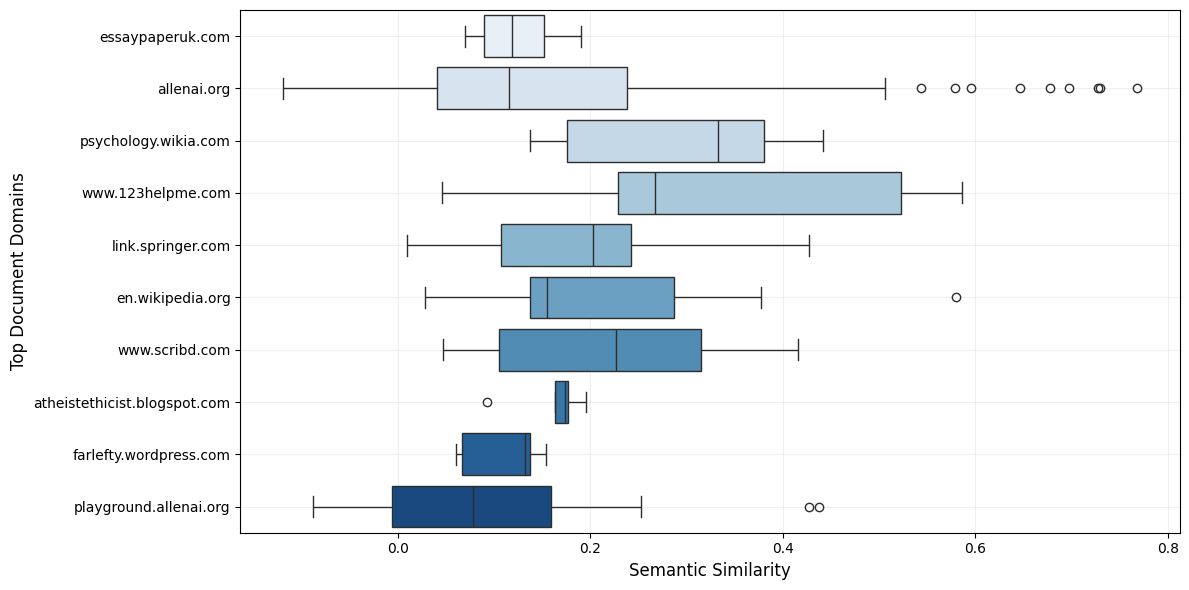

In [16]:
# des

# Extract domain and filter top N
merged['domain'] = merged['document_url'].apply(lambda x: urlparse(str(x)).netloc)
top_domains = merged['domain'].value_counts().head(10).index
top_data = merged[merged['domain'].isin(top_domains)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_data, y='domain', x='similarity', palette="Blues", linewidth=1)
# plt.title("Cosine Similarity Between Model Reasoning and Source Texts by Domain", fontsize=14, weight='bold')
plt.xlabel("Semantic Similarity", fontsize=12)
plt.ylabel("Top Document Domains", fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("docbox.pdf", bbox_inches="tight")
plt.show()


In [ ]:
### THIS ONE ###

# Extract domain and filter top N
merged['domain'] = merged['document_url'].apply(lambda x: urlparse(str(x)).netloc)
top_domains = merged['domain'].value_counts().head(10).index
top_data = merged[merged['domain'].isin(top_domains)]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=top_data, y='domain', x='similarity',
    palette="Blues", linewidth=1
)

plt.xlabel("", fontsize=20, labelpad=10)
plt.ylabel("", fontsize=20, labelpad=10)
plt.xticks(fontsize=18, weight="bold")
plt.yticks(fontsize=16, weight = "bold")  # slightly smaller for long domain names
plt.grid(alpha=0.25, axis="x")

plt.tight_layout()
# plt.savefig("olmo_box.pdf", bbox_inches="tight")
plt.show()


In [88]:
from urllib.parse import urlparse
import textwrap

def shorten_domain(netloc: str) -> str:
    if not netloc:
        return ""
    host = netloc.split(":")[0].lower()

    SPECIAL = {
        "en.wikipedia.org": "Wikipedia",
        "wikipedia.org": "Wikipedia",
        "link.springer.com": "Springer",
        "springer.com": "Springer",
        "allenai.org": "AllenAI",
        "playground.allenai.org": "Ai2 playground",
    }
    if host in SPECIAL:
        return SPECIAL[host]

    parts = host.split(".")
    if len(parts) < 2:
        return host

    base = parts[-2]
    sub = ".".join(parts[:-2])

    ignore = {"www", "en", "m", "link", "amp"}
    if sub and sub not in ignore:
        return f"{base.title()}"
    return base.title()

/tmp/ipykernel_714068/1984578189.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_714068/1984578189.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels, fontsize=22, weight="bold")


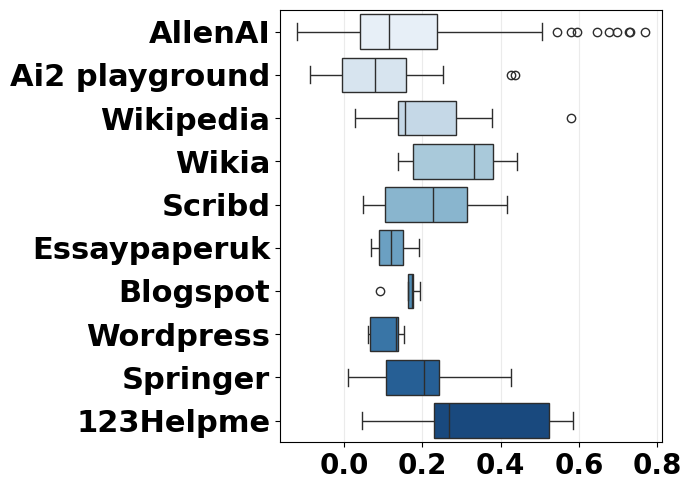

In [96]:
### THIS ONE ###
import textwrap
import matplotlib.patches as mpatches

merged['domain'] = merged['document_url'].apply(lambda x: urlparse(str(x)).netloc)
top_domains = merged['domain'].value_counts().head(10).index
merged["domain_short"] = merged["domain"].apply(shorten_domain)

order = [shorten_domain(d) for d in top_domains]

top_data = merged[merged["domain"].isin(top_domains)].copy()

plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=top_data, y="domain_short", x="similarity",
    order=order, palette="Blues", linewidth=1
)

ax.set_axisbelow(True)

# n = len(order)

# for i in range(n):
#     if i % 2 == 1:
#         y0, y1 = (i-1) / n, (i) / n

#         rect = mpatches.Rectangle(
#             (-0.05, y0),
#             1.1, 
#             y1 - y0, 
#             transform=ax.transAxes,
#             facecolor="#586F7C", alpha=0.1,
#             zorder=0, linewidth=0
#         )
#         ax.add_patch(rect)

plt.xlabel("", fontsize=20, labelpad=10)
plt.ylabel("", fontsize=20, labelpad=10)
plt.xticks(fontsize=20, weight="bold")
plt.yticks(fontsize=22, weight="bold")

# Wrap y-axis tick labels for long domain names and set background color
wrap_width = 30
ylabels = [textwrap.fill(label.get_text(), wrap_width) for label in ax.get_yticklabels()]
ax.set_yticklabels(ylabels, fontsize=22, weight="bold")

# # Set background color for ytick label text
# ytick_color = "#586F7C"  # a very light blue, adjust as needed
# for i, label in enumerate(ax.get_yticklabels()):
#     if i%2 == 1:
#         label.set_bbox(dict(facecolor=ytick_color, edgecolor='none', alpha=0.1))

plt.grid(alpha=0.25, axis="x")

plt.tight_layout()
plt.savefig("olmo_box_new.pdf", bbox_inches="tight")
plt.show()


Certain domains consistently align more closely with model reasoning, indicating the model internalizes structured moral concepts more effectively from psychology, education, and Q&A sources.

#### Bar Plot - Average Similarity by Domain

In [7]:
# avg_sim_by_domain = merged.groupby('domain')['similarity'].mean().sort_values(ascending=False).head(15)

# plt.figure(figsize=(10, 5))
# avg_sim_by_domain.plot(kind='barh')
# plt.title("Average Semantic Similarity to Model Reasoning by Domain")
# plt.xlabel("Average Cosine Similarity")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()


In [8]:
# # des

# avg_sim = merged.groupby('domain')['similarity'].mean().sort_values(ascending=False).head(15)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=avg_sim.values, y=avg_sim.index, palette="crest")
# plt.title("Average Similarity to Model Reasoning by Document Domain", fontsize=14, weight='bold')
# plt.xlabel("Average Cosine Similarity", fontsize=12)
# plt.ylabel("Domain", fontsize=12)
# plt.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.show()


Domains offering accessible ethical discussions — including blogs and forums — tend to show higher average alignment, suggesting that clarity and example-driven content aids model learning.

#### Bar plot - Top 10 Most Semantically Aligned Sources

/tmp/ipykernel_714068/3384674369.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


PermissionError: [Errno 13] Permission denied: 'sembar.pdf'

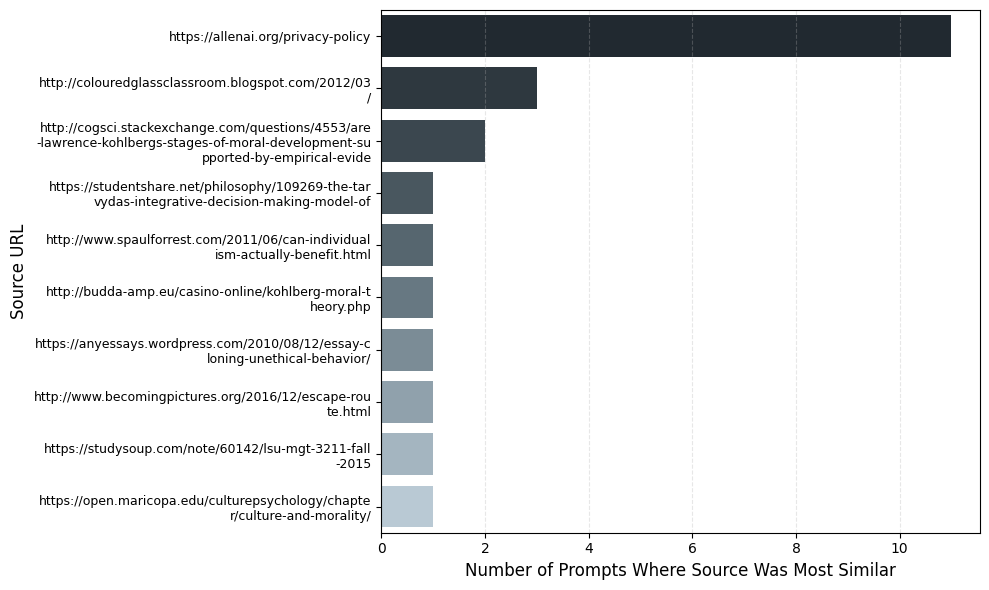

In [98]:
top_docs = merged.loc[merged.groupby('prompt_id')['similarity'].idxmax()]

# Top 10 most influential documents
top_sources = top_docs['document_url'].value_counts().head(10)

def wrap_url(url, width=50):
    return '\n'.join([url[i:i+width] for i in range(0, len(url), width)])

top_sources.index = top_sources.index.map(wrap_url)

# plot with clean layout
plt.figure(figsize=(10, 6))
pal = sns.blend_palette(["#1E2A32", "#586F7C", "#B4CAD9"], n_colors=len(top_sources))

ax = sns.barplot(
    x=top_sources.values,
    y=top_sources.index,
    palette=pal,                 # top bar (first) gets the darkest tone
    linewidth=0.8
)
# plt.title("Top 10 Most Semantically Aligned Sources with Model Reasoning", fontsize=14, weight='bold')
plt.xlabel("Number of Prompts Where Source Was Most Similar", fontsize=12)
plt.ylabel("Source URL", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.savefig("sembar.pdf", bbox_inches="tight")
plt.show()



A small number of documents appear repeatedly as the most semantically similar source, highlighting the model’s reliance on specific sources as moral reasoning templates across diverse prompts

## Text analysis - LLAMA 8B

Label source type using llm as judge - used script to use llamam for this

In [99]:
# check to make sure all source types are labelled
df = pd.read_csv("merged_labeled_llama8b.csv")
print({
    "total": len(df),
    "labeled": df["text_type_category"].notna().sum(),
    "remaining": df["text_type_category"].isna().sum(),
})

{'total': 3323, 'labeled': np.int64(3323), 'remaining': np.int64(0)}


Visualise the results as stack bar plot

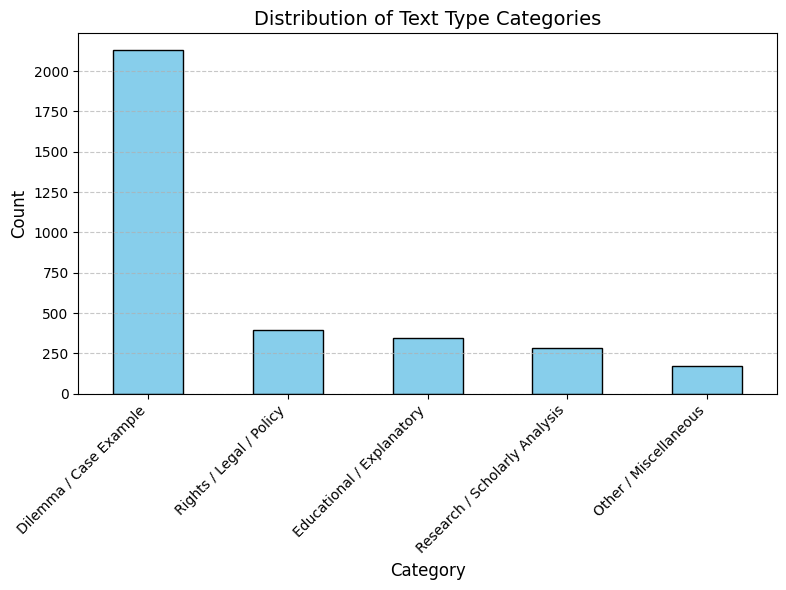

In [100]:
if "text_type_category" not in df.columns:
    raise ValueError("The column 'text_type_category' does not exist in merged")

## raw stacked bar chart
# Count category frequencies
category_counts = df["text_type_category"].value_counts()

# Plot
plt.figure(figsize=(8, 6))
category_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Distribution of Text Type Categories", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


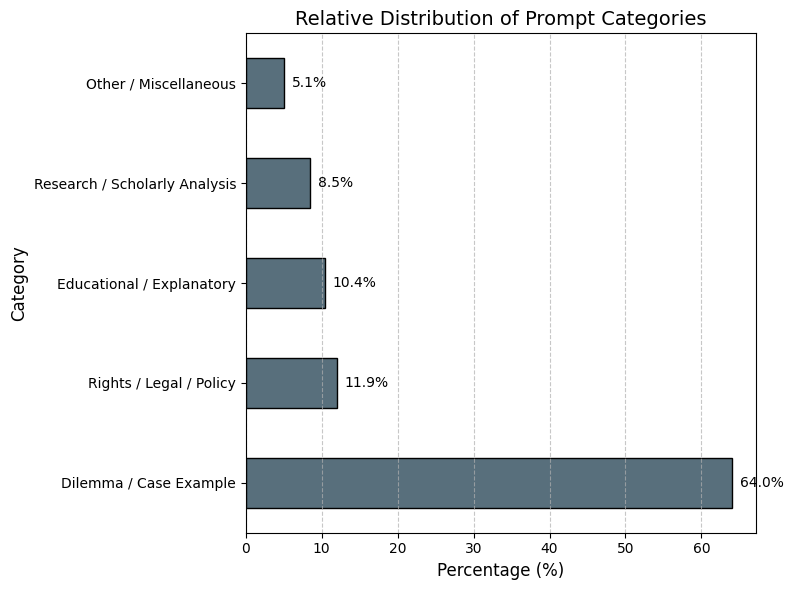

In [101]:
## proportions bar visual

category_props = df["text_type_category"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
category_props.plot(kind="barh", color="#586F7C", edgecolor="black")

plt.title("Relative Distribution of Prompt Categories", fontsize=14)
plt.xlabel("Percentage (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

for i, v in enumerate(category_props):
    plt.text(v + 1, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


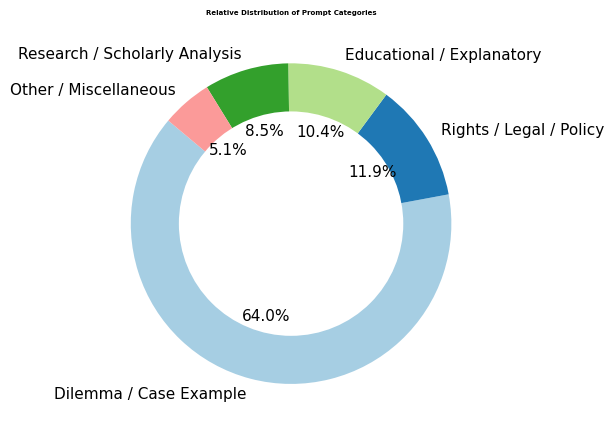

In [102]:
# donut

# proportions
category_props = df["text_type_category"].value_counts(normalize=True) * 100

# colors (customizable)
colors = plt.cm.Paired(range(len(category_props)))

plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    category_props,
    labels=category_props.index,
    autopct="%.1f%%",
    startangle=140,
    colors=colors,
    textprops={"fontsize": 11, "color": "black"}
)

# make it a donut by adding a white circle
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Relative Distribution of Prompt Categories", fontsize=5, weight="bold")
plt.tight_layout()
plt.show()


PermissionError: [Errno 13] Permission denied: 'textcats.pdf'

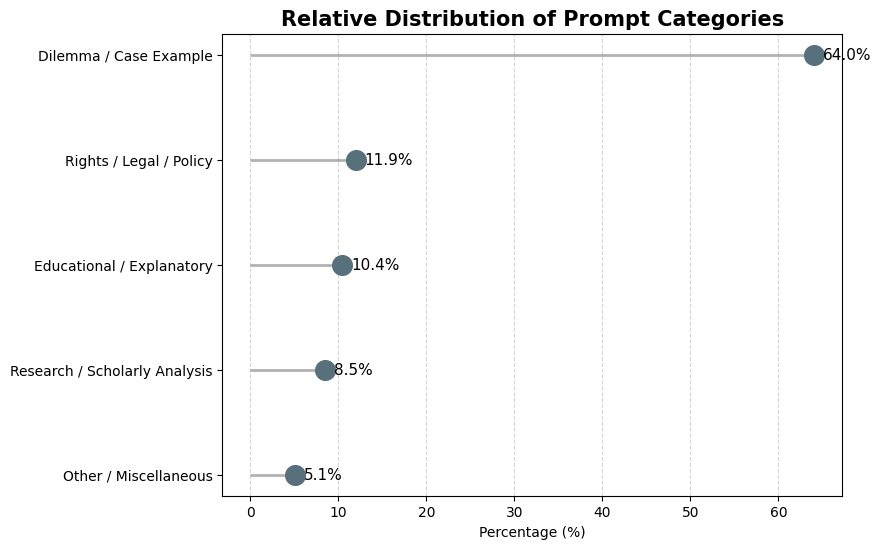

In [103]:
import matplotlib.pyplot as plt

category_props = df["text_type_category"].value_counts(normalize=True) * 100
category_props = category_props.sort_values()  # optional: sorted view

fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=category_props.index, xmin=0, xmax=category_props, color="grey", alpha=0.6, linewidth=2)
ax.scatter(category_props, category_props.index, s=200, color="#586F7C", zorder=3)

# add labels
for i, v in enumerate(category_props):
    ax.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=11)

ax.set_title("Relative Distribution of Prompt Categories", fontsize=15, weight="bold")
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.5)
# plt.tight_layout()

plt.savefig("textcats.pdf", bbox_inches="tight")

plt.show()

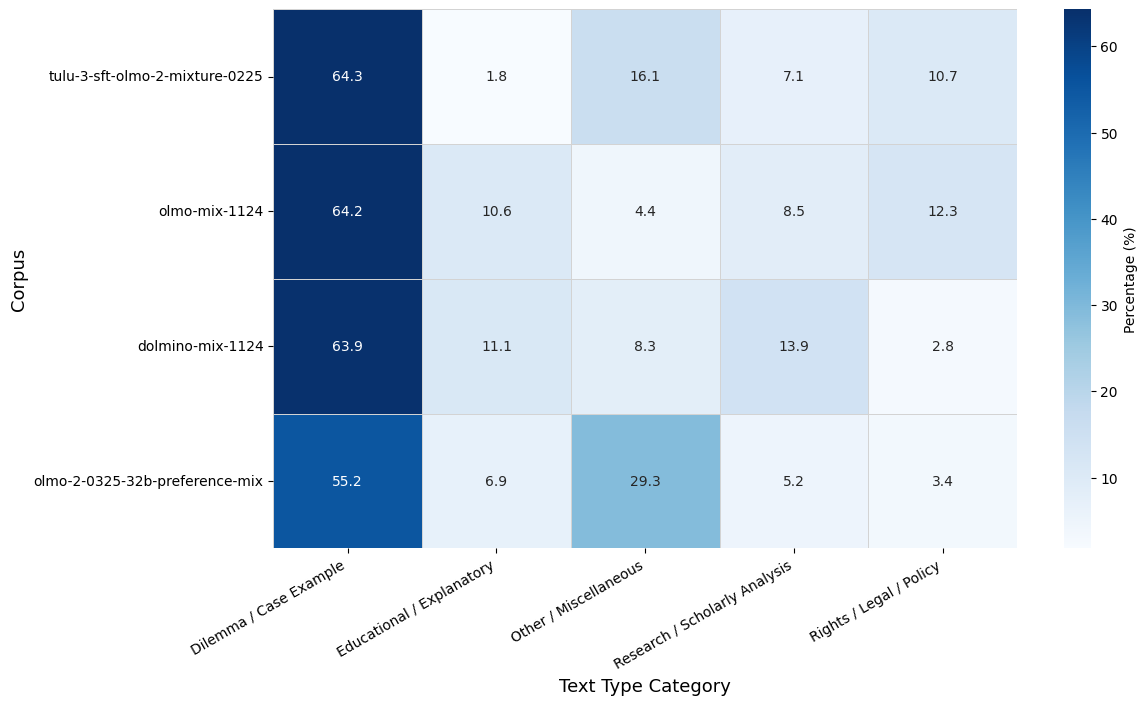

In [104]:
# Plot: Heatmap of corpus_name × text_type_category.
# Why: Reveals which corpora contribute more dilemma-style content vs. explanatory vs. rights.

# Crosstab with row percentages
pivot = pd.crosstab(
    df["corpus_name"],
    df["text_type_category"],
    normalize="index"
) * 100

# Sort rows by one category (optional, makes heatmap cleaner)
pivot = pivot.sort_values(by=pivot.columns[0], ascending=False)

plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='lightgrey'
)

# plt.title("Proportion of Categories by Corpus", fontsize=16, weight="bold", pad=15)
plt.xlabel("Text Type Category", fontsize=13)
plt.ylabel("Corpus", fontsize=13)

plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
# plt.tight_layout()

plt.savefig("textcatsbycorpus.pdf", bbox_inches="tight")

plt.show()


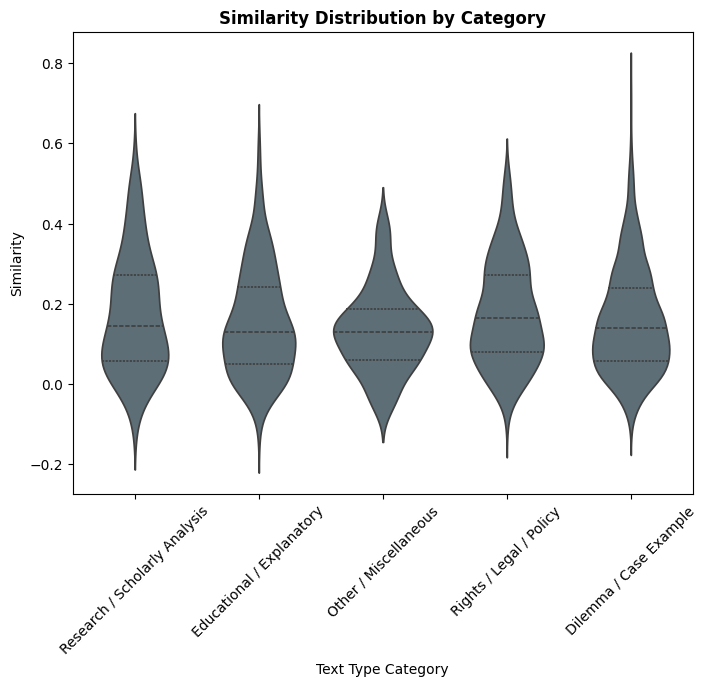

In [105]:
# Plot: Boxplot or violin plot of similarity grouped by text_type_category.
# Why: Lets you see whether certain types of content (like dilemmas) are closer/further from model responses.

plt.figure(figsize=(8,6))
sns.violinplot(data=df, color = "#586F7C", x="text_type_category", y="similarity", inner="quartile")
plt.xticks(rotation=45)
plt.title("Similarity Distribution by Category", weight = "bold")
plt.xlabel("Text Type Category")
plt.ylabel("Similarity")

# plt.savefig("textcatssimilarity.pdf", bbox_inches="tight")
plt.show()

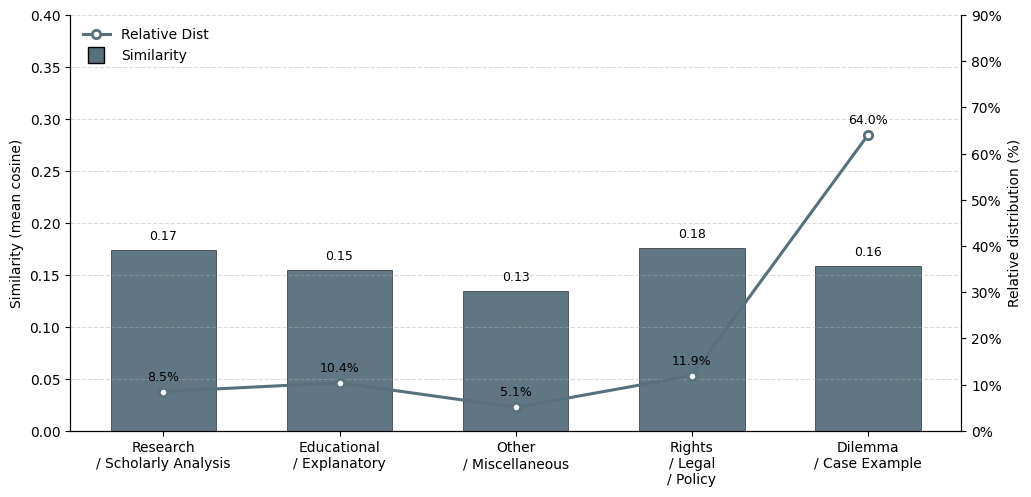

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, PercentFormatter

# ---- INPUTS ---------------------------------------------------------
# df must have: 'text_type_category' and 'similarity'
# Example category order (edit if you prefer a different order):
category_order = [
    "Research / Scholarly Analysis",
    "Educational / Explanatory",
    "Other / Miscellaneous",
    "Rights / Legal / Policy",
    "Dilemma / Case Example",
]

COLOR = "#586F7C"  # requested color

# ---- AGGREGATES -----------------------------------------------------
counts = df["text_type_category"].value_counts().reindex(category_order).fillna(0)
rel_pct = counts / counts.sum() * 100

# use median (robust); switch to .mean() if you want averages
sim_by_cat = (
    df.groupby("text_type_category")["similarity"]
      .mean()
      .reindex(category_order)
      .fillna(0)
)

# ---- PLOT -----------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(11.5, 5.4))  # wide so labels are readable
x = np.arange(len(category_order))

# Bars = similarity (left axis)
bar_width = 0.6
bars = ax1.bar(
    x, sim_by_cat.values, width=bar_width,
    color=COLOR, alpha=0.95, edgecolor="black", linewidth=0.4
)

# Left axis formatting
ymax_left = float(np.ceil((sim_by_cat.max() * 1.25) / 0.05) * 0.05) or 0.25
ymax_left = max(0.4, ymax_left)  # ensure decent headroom
ax1.set_ylim(0, ymax_left)
ax1.set_ylabel("Similarity (mean cosine)")
ax1.yaxis.set_major_locator(MultipleLocator(0.05))
ax1.grid(axis="y", linestyle="--", alpha=0.45)
ax1.spines["top"].set_visible(False)

# Right axis = relative distribution (%)
ax2 = ax1.twinx()
line = ax2.plot(
    x, rel_pct.values, marker="o", linewidth=2.2,
    markerfacecolor="white", markeredgecolor=COLOR, markeredgewidth=2,
    color=COLOR
)[0]

ymax_right = int(np.ceil(rel_pct.max() * 1.25 / 10) * 10)
ymax_right = min(100, max(60, ymax_right))  # keep within [60..100]
ax2.set_ylim(0, ymax_right)
ax2.set_ylabel("Relative distribution (%)")
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.spines["top"].set_visible(False)

# X labels (wrapped for readability)
def wrap_label(s):
    return s.replace(" / ", "\n/ ")

ax1.set_xticks(x)
ax1.set_xticklabels([wrap_label(c) for c in category_order], ha="center")

# # Title
# ax1.set_title("Similarity (bars) vs. Relative Distribution (line) by Text Category", pad=12)

# Annotations (values on bars and points)
for xi, v in enumerate(sim_by_cat.values):
    ax1.text(xi, v + ymax_left*0.018, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

for xi, p in enumerate(rel_pct.values):
    ax2.text(xi, p + ymax_right*0.020, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

# Legend (custom)
legend_items = [
    Line2D([0], [0], color=COLOR, marker='o', lw=2.2, markerfacecolor="white",
           markeredgecolor=COLOR, markeredgewidth=2, label="Relative Dist"),
    Line2D([0], [0], color=COLOR, lw=0, marker='s', markersize=12,
           markerfacecolor=COLOR, markeredgecolor="black", label="Similarity"),
]
ax1.legend(handles=legend_items, loc="upper left", frameon=False)

# fig.tight_layout()
# plt.savefig("cats_combined_v2.pdf", bbox_inches="tight")
plt.show()


## Text analysis - LLAMA 70B - USE THIS FOR PAPER

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# check to make sure all source types are labelled
df = pd.read_csv("merged_labeled_llama70b.csv")
print({
    "total": len(df),
    "labeled": df["text_type_category"].notna().sum(),
    "remaining": df["text_type_category"].isna().sum(),
})

{'total': 3323, 'labeled': np.int64(3323), 'remaining': np.int64(0)}


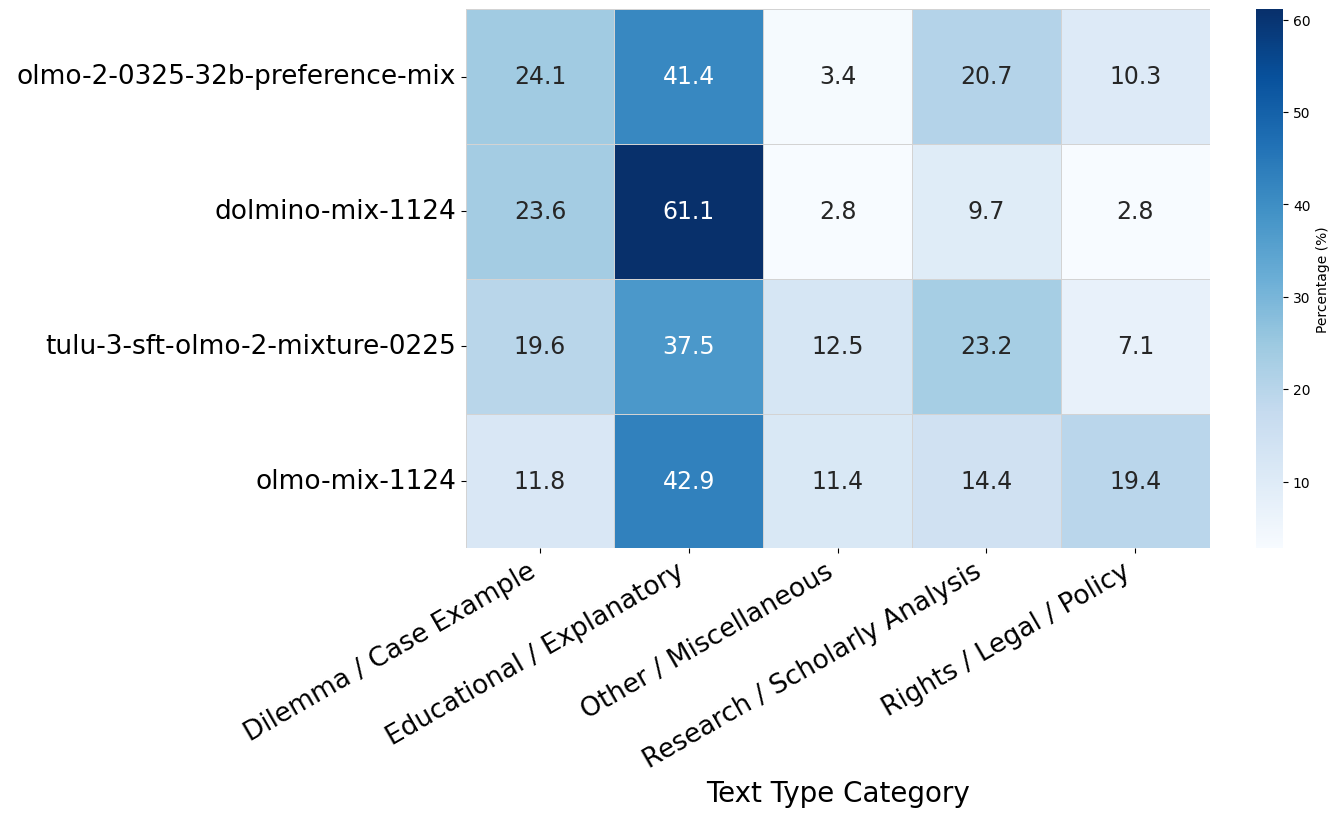

In [5]:
# Plot: Heatmap of corpus_name × text_type_category.
# Why: Reveals which corpora contribute more dilemma-style content vs. explanatory vs. rights.

# Crosstab with row percentages
pivot = pd.crosstab(
    df["corpus_name"],
    df["text_type_category"],
    normalize="index"
) * 100

# Sort rows by one category (optional, makes heatmap cleaner)
pivot = pivot.sort_values(by=pivot.columns[0], ascending=False)

plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='lightgrey',
    annot_kws={"size": 17}
)

# plt.title("Proportion of Categories by Corpus", fontsize=16, weight="bold", pad=15)
plt.xlabel("Text Type Category", fontsize=20)
plt.ylabel(" ", fontsize=1)

plt.xticks(rotation=30, ha="right", fontsize=19)
plt.yticks(rotation=0, fontsize=19)
# plt.tight_layout()

# plt.savefig("textcatsbycorpus70b.pdf", bbox_inches="tight")

plt.show()


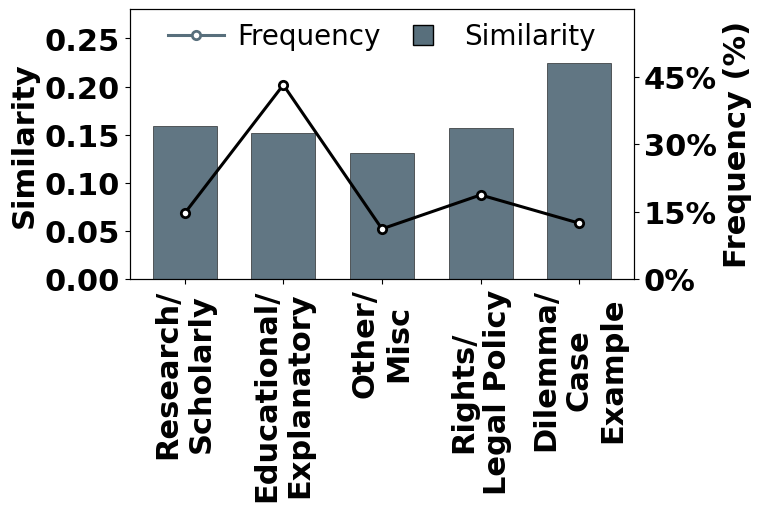

In [94]:
### THIS ONE ###
from matplotlib.ticker import MaxNLocator, MultipleLocator, PercentFormatter
from matplotlib.lines import Line2D

category_order = [
    "Research / Scholarly Analysis",
    "Educational / Explanatory",
    "Other / Miscellaneous",
    "Rights / Legal / Policy",
    "Dilemma / Case Example",
]

sim_by_cat = (
    df.groupby("text_type_category")["similarity"]
      .mean()
      .reindex(category_order)
      .fillna(0)
)

COLOR = "#586F7C"  # requested color

counts = df["text_type_category"].value_counts().reindex(category_order).fillna(0)
rel_pct = counts / counts.sum() * 100

fig, ax1 = plt.subplots(figsize=(7.5, 5), constrained_layout=True)
x = np.arange(len(category_order))

# Bars
bars = ax1.bar(
    x, sim_by_cat.values, width=0.65,
    color=COLOR, alpha=0.95, edgecolor="black", linewidth=0.4
)

# Left axis (shorter ylim)
ymax_left = sim_by_cat.max() * 1.25  # 25% headroom above max bar
ax1.set_ylim(0, ymax_left)
ax1.set_ylabel("Similarity", fontsize=22, weight='bold')
ax1.yaxis.set_major_locator(MultipleLocator(0.05))
ax1.tick_params(axis='y', labelsize=18)

# Right axis
ax2 = ax1.twinx()

ax2.plot(
    x, rel_pct.values, marker="o", linewidth=2.2,
    markerfacecolor="white", markeredgecolor='black', markeredgewidth=2,
    color='black'
)
ymax_right = int(np.ceil(rel_pct.max() * 1.25 / 10) * 10)
ymax_right = min(100, max(60, ymax_right))  # keep within [60..100]
ax2.set_ylabel("Frequency (%)", fontsize=22, weight='bold')
ax2.set_ylim(0, ymax_right)
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5, prune="upper"))
ax2.tick_params(axis='y', labelsize=18)

# --- X labels (less crowded) ---
label_map = {
    "Research / Scholarly Analysis": "Research/\nScholarly",
    "Educational / Explanatory": "Educational/\nExplanatory",
    "Other / Miscellaneous": "Other/\nMisc",
    "Rights / Legal / Policy": "Rights/\nLegal Policy",
    "Dilemma / Case Example": "Dilemma/\nCase\nExample"
}
ax1.set_xticks(x)
ax1.set_xticklabels([label_map.get(c, c) for c in category_order],
                    ha="center", fontsize=22, rotation=90, fontweight = "bold")

for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize('22')
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize('22')

# Extra margin so labels breathe
plt.margins(x=0.1)

# # Annotations
# for xi, v in enumerate(sim_by_cat.values):
#     ax1.text(xi, v + ymax_left*-0.12, f"{v:.2f}",
#              ha="center", va="bottom", fontsize=18, weight='bold', color='white')
# for xi, p in enumerate(rel_pct.values):
#     if xi == 1:
#         ax2.text(xi, p + ymax_right*0.01, f"{p:.1f}",
#              ha="center", va="bottom", fontsize=18, weight='bold', color='black')
#     else:
#         ax2.text(xi, p + ymax_right*-0.12, f"{p:.1f}",
#                 ha="center", va="bottom", fontsize=18, weight='bold', color='black')

# Legend (inside, lower position)
legend_items = [
    Line2D([0], [0], color=COLOR, marker='o', lw=2.2,
           markerfacecolor="white", markeredgecolor=COLOR, markeredgewidth=2,
           label="Frequency"),
    Line2D([0], [0], color=COLOR, lw=0, marker='s', markersize=15,
           markerfacecolor=COLOR, markeredgecolor="black",
           label="Similarity"),
]
ax1.legend(
    handles=legend_items,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),
    frameon=False,
    fontsize=20,
    borderaxespad=0,  # Remove padding between legend and axes
    borderpad=0,      # Remove padding inside the legend box
    handletextpad=0.5, # Minimal space between handle and text
    columnspacing=0.5, # Minimal space between columns if any
    labelspacing=0.2,   # Minimal vertical space between entries
    ncol=2
)

plt.savefig("cats_combined70b_font_new.pdf", bbox_inches="tight")
plt.show()
